# Intel Image Classification

In [27]:
# Install Kaggle API
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json API token

# Configure Kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau


# Download dataset
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -q intel-image-classification.zip

In [28]:
# setting up path and view types of classes
train_dir = '/content/seg_train/seg_train'
test_dir = '/content/seg_test/seg_test'

classes = os.listdir(train_dir)
print("Classes: ",classes)

Classes:  ['buildings', 'street', 'glacier', 'sea', 'mountain', 'forest']


# Analyzing

In [29]:
#count of images
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")
total = sum(len(os.listdir(os.path.join(train_dir, cls))) for cls in classes)
print(f"Total images are {total}")

buildings: 2191 images
street: 2382 images
glacier: 2404 images
sea: 2274 images
mountain: 2512 images
forest: 2271 images
Total images are 14034


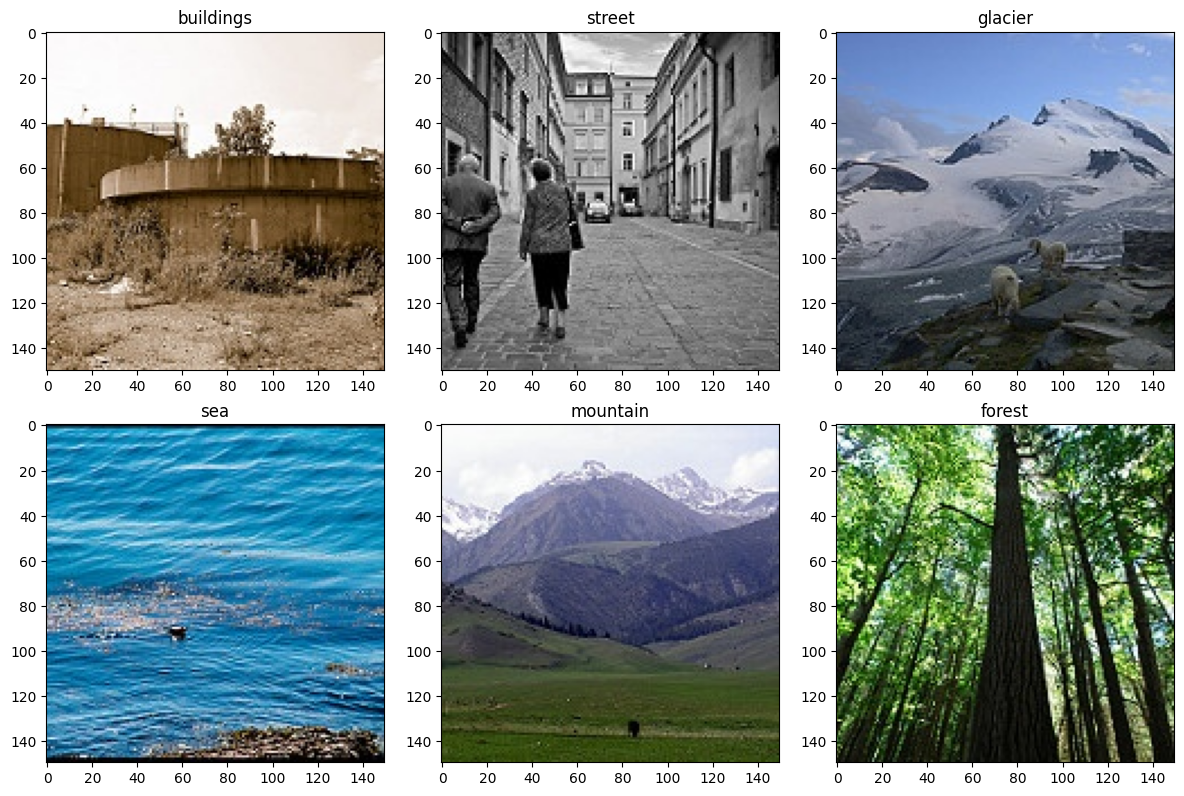

In [30]:
# assign and view images of classes
classes = os.listdir(train_dir)

plt.figure(figsize=(12,8))
for i,cls in enumerate(classes):
    cls_path = os.path.join(train_dir,cls)
    img_path = os.path.join(cls_path,os.listdir(cls_path)[0])
    img = Image.open(img_path)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(cls)

plt.tight_layout()
plt.show()

# Creating pipelines

In [31]:
#pipelines

img_size = (150,150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [32]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    shuffle = False,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3000 images belonging to 6 classes.


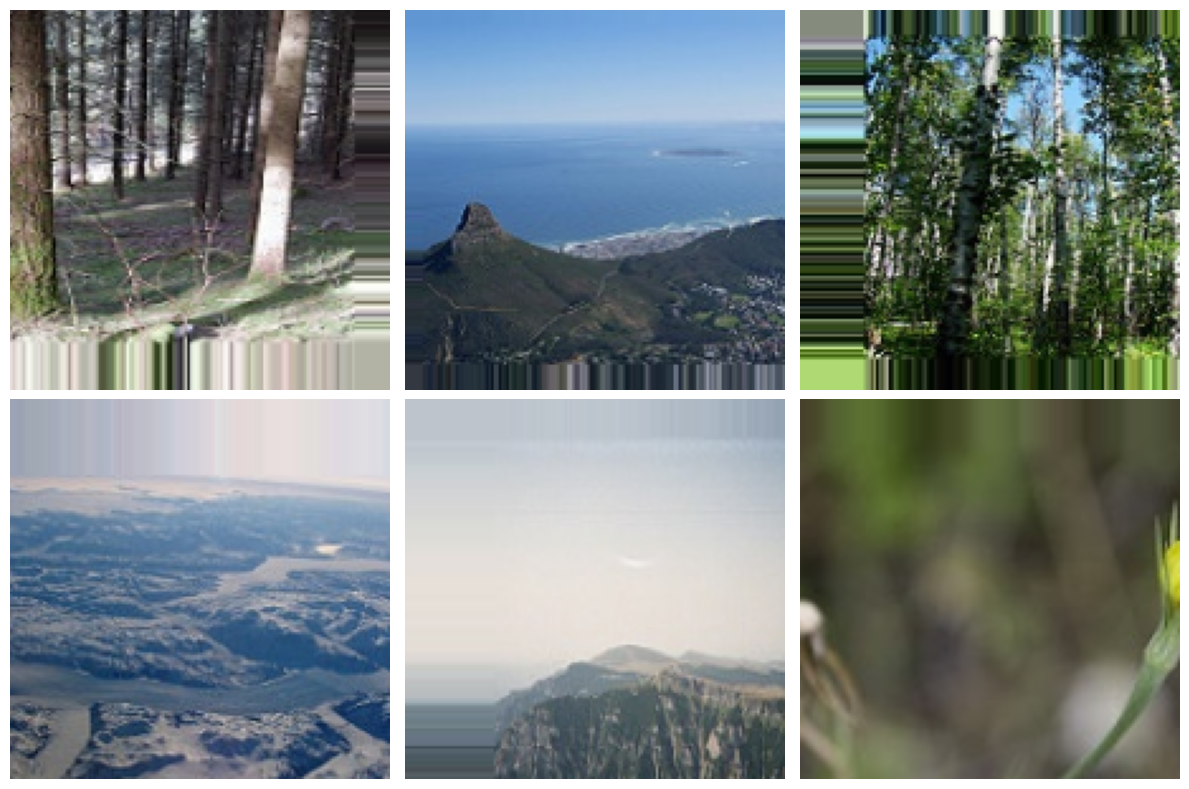

In [33]:
x_batch , y_batch = next(train_generator)

plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [34]:
#verifying shape
x_batch.shape,y_batch.shape

((32, 150, 150, 3), (32, 6))

# Contructing CNN Sequential with Dense Layers

In [35]:
def cnn_model():
    model = Sequential([

    Conv2D(filters=128,kernel_size=(5,5),padding='valid',input_shape=(150,150,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(filters=64,kernel_size=(3,3),padding='valid'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(filters=32,kernel_size=(3,3),padding='valid'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(6,activation='softmax'),

])
    return model

In [36]:
cnn_model = cnn_model()
print(cnn_model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 146, 146, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 146, 146, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 73, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 71, 71, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 71, 71, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 35, 35, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 33, 33, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 33, 33, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,152,358 (4.40 MB)

 Trainable params: 1,151,910 (4.39 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [37]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor = np.sqrt(0.1),
    patience = 10,
    verbose=2
)

# Using Categorical Cross Entropy

In [38]:
cnn_model.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

In [39]:
history = cnn_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs=35,
    validation_data=validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    callbacks = [reduce_lr]
)

Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 108s 278ms/step - accuracy: 0.3547 - loss: 7.9815 - val_accuracy: 0.4810 - val_loss: 1.2034 - learning_rate: 0.0100
Epoch 2/35
  1/350 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.3750 - loss: 1.5848

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3750 - loss: 1.5848 - val_accuracy: 0.5000 - val_loss: 1.3243 - learning_rate: 0.0100
Epoch 3/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 90s 254ms/step - accuracy: 0.4326 - loss: 1.3660 - val_accuracy: 0.1936 - val_loss: 26.5608 - learning_rate: 0.0100
Epoch 4/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.4688 - loss: 1.2299 - val_accuracy: 0.1500 - val_loss: 26.8038 - learning_rate: 0.0100
Epoch 5/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 139s 259ms/step - accuracy: 0.4624 - loss: 1.3274 - val_accuracy: 0.5025 - val_loss: 1.1797 - learning_rate: 0.0100
Epoch 6/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4062 - loss: 1.4054 - val_accuracy: 0.3000 - val_loss: 1.3343 - learning_rate: 0.0100
Epoch 7/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 135s 248ms/step - accuracy: 0.5032 - loss: 1.2282 - val_accuracy: 0.4192 - val_loss: 1.4834 - learning_rate: 0.0100
Epoch 8/35
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step - accuracy: 0.6250 - loss: 0.89

In [40]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['learning_rate']

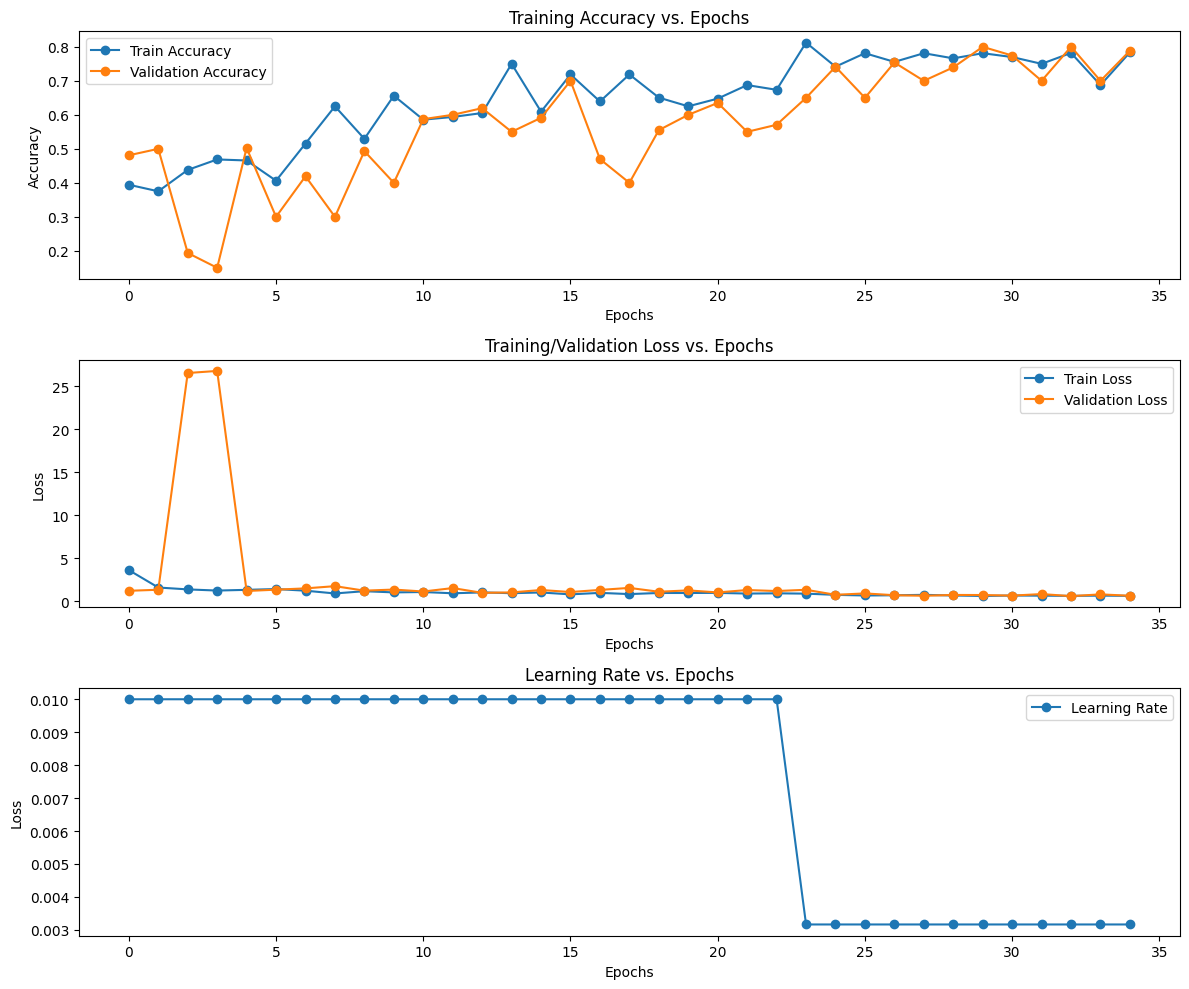

In [41]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [42]:
test_loss, test_accuracy = cnn_model.evaluate(
    test_generator,
    steps=test_generator.samples // batch_size
)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.8432 - loss: 0.4399
Test Loss: 0.5283822417259216
Test Accuracy: 0.8161962628364563


# Our model is performing excellently lets explore further

In [43]:
import numpy as np
predictions = cnn_model.predict(test_generator )

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step


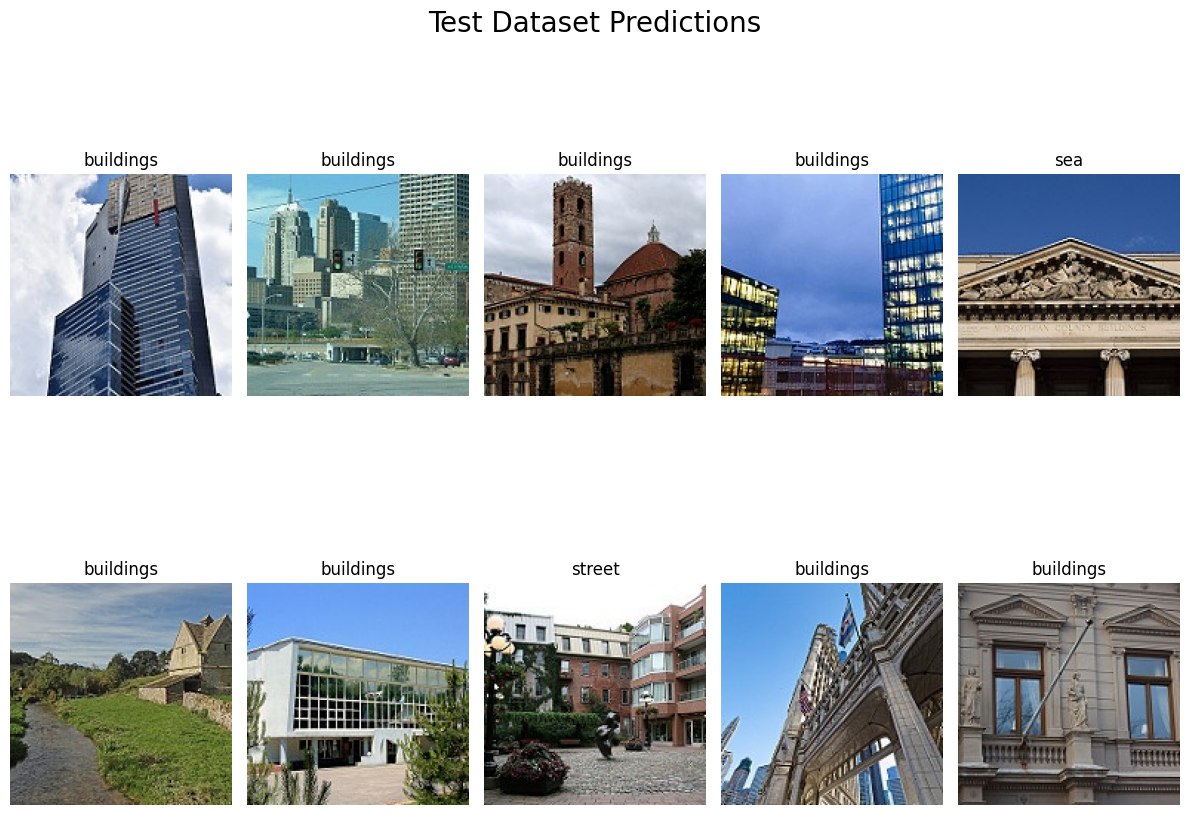

In [44]:
labels = {value: key for key, value in train_generator.class_indices.items()}
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [45]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

true_classes.shape

(3000,)

True Class: 0 | Predicted Class: 0
True Class: 0 | Predicted Class: 0
True Class: 0 | Predicted Class: 0
True Class: 0 | Predicted Class: 0
True Class: 0 | Predicted Class: 4
True Class: 0 | Predicted Class: 0
True Class: 0 | Predicted Class: 0
True Class: 0 | Predicted Class: 5
True Class: 0 | Predicted Class: 0
True Class: 0 | Predicted Class: 0


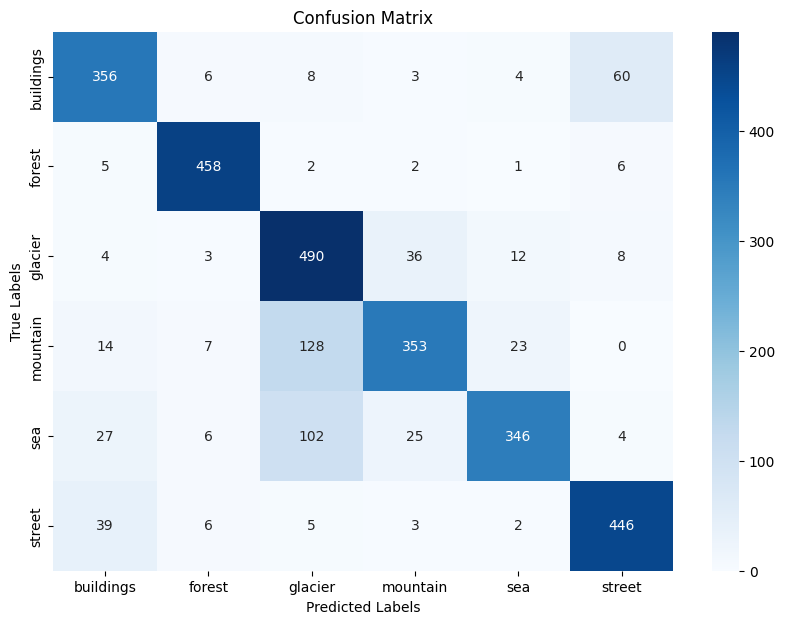

In [46]:
for i in range(10):
    print(f"True Class: {true_classes[i]} | Predicted Class: {predicted_classes[i]}")

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels.values(), yticklabels=labels.values(),
)

#xticklabels=labels.values(), yticklabels=labels.values(),
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [47]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
print(classification_report(true_classes,predicted_classes, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.80      0.81      0.81       437
      forest       0.94      0.97      0.95       474
     glacier       0.67      0.89      0.76       553
    mountain       0.84      0.67      0.75       525
         sea       0.89      0.68      0.77       510
      street       0.85      0.89      0.87       501

    accuracy                           0.82      3000
   macro avg       0.83      0.82      0.82      3000
weighted avg       0.83      0.82      0.82      3000



In [48]:
report = classification_report(true_classes, predicted_classes, target_names=labels.values(), output_dict=True)

# Overall metrics
accuracy = report['accuracy']  # Overall accuracy
weighted_precision = report['weighted avg']['precision']
weighted_recall = report['weighted avg']['recall']
weighted_f1 = report['weighted avg']['f1-score']

print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"Weighted F1-Score: {weighted_f1}")

Accuracy: 0.8163333333333334
Weighted Precision: 0.8284447570063322
Weighted Recall: 0.8163333333333334
Weighted F1-Score: 0.8153998655514406
